Date: 2016-01-25

In [22]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%reload_ext snakeviz

from collections import namedtuple
from functools import partial, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.data_processing import (get_interpolated_position_dataframe,
                                 get_mark_indicator_dataframe,
                                 make_tetrode_dataframe, reshape_to_segments)
from src.analysis import (detect_epoch_ripples, decode_ripple_clusterless,
                          get_ripple_info, _compute_decision_state_probability)
from src.ripple_decoding import (combined_likelihood,
                                 estimate_marked_encoding_model,
                                 joint_mark_intensity, poisson_mark_likelihood,
                                 predict_state,
                                 _get_bin_centers, estimate_state_transition,
                                 set_initial_conditions, evaluate_mark_space, _normal_pdf)

In [2]:
Animal = namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

In [3]:
epoch_index = ('HPa', 6, 2)
print('\nDecoding ripples for Animal {0}, Day {1}, Epoch #{2}:'.format(
    *epoch_index))


Decoding ripples for Animal HPa, Day 6, Epoch #2:


In [4]:
n_place_bins = 61
place_std_deviation = None

## Encoding

In [5]:
def _convert_to_states(function):
    @wraps(function)
    def wrapper(*args, **kwargs):
        d = function(*args, **kwargs)
        return [d['Outbound'], d['Outbound'],
                d['Inbound'], d['Inbound']]
    return wrapper


@_convert_to_states
def _get_place(position_info):
    return {trajectory_direction: grouped.loc[:, 'linear_distance'].values
            for trajectory_direction, grouped
            in (position_info
                .groupby('trajectory_direction'))}


@_convert_to_states
def _get_place_at_spike(mark_tetrode_data, position_info):
    return {trajectory_direction: grouped.dropna().linear_distance.values
            for trajectory_direction, grouped
            in (mark_tetrode_data
                .join(position_info)
                .groupby('trajectory_direction'))}


@_convert_to_states
def _get_training_marks(mark_tetrode_data, position_info, mark_variables):
    return {trajectory_direction: (grouped.dropna()
                                   .loc[:, mark_variables].values)
            for trajectory_direction, grouped
            in (mark_tetrode_data
                .join(position_info)
                .groupby('trajectory_direction'))}

In [6]:
tetrode_info = make_tetrode_dataframe(animals)[
    epoch_index]

tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :]

area  depth descrip  numcells animal  \
animal day epoch_ind tetrode_number                                         
HPa    6   2         1                CA1    114  riptet         7    HPa   
                     2                CA1    121     NaN         0    HPa   
                     4                CA1    117  riptet         8    HPa   
                     5                CA1    117  riptet         5    HPa   
                     6                CA1    110  riptet         0    HPa   
                     7                CA1    114  riptet         0    HPa   
                     8               iCA1    114  riptet         1    HPa   
                     9               iCA1    101  riptet         1    HPa   
                     10              iCA1     98     NaN         1    HPa   
                     11              iCA1    108  riptet         1    HPa   
                     12              iCA1    116  riptet         1    HPa   
                     13              iCA1    120     NaN         0    HPa   
                     14              iCA1    105  riptet         1    HPa   

                                     day  epoch_ind  tetrode_number tetrode_id  
animal day epoch_ind tetrode_number                                             
HPa    6   2         1                 6          2               1     HPa621  
                     2                 6          2               2     HPa622  
                     4                 6          2               4     HPa624  
                     5                 6          2               5     HPa625  
                     6                 6          2               6     HPa626  
                     7                 6          2               7     HPa627  
                     8                 6          2               8     HPa628  
                     9                 6          2               9     HPa629  
                     10                6          2              10    HPa6210  
                     11                6          2              11    HPa6211  
                     12                6          2              12    HPa6212  
                     13                6          2              13    HPa6213  
                     14                6          2              14    HPa6214

In [7]:
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :]
tetrode_marks = [(get_mark_indicator_dataframe(tetrode_index, animals)
                  .loc[:, mark_variables])
                 for tetrode_index in hippocampal_tetrodes.index]

position_variables = ['linear_distance', 'trajectory_direction',
                      'speed']
position_info = (get_interpolated_position_dataframe(
    epoch_index, animals).loc[:, position_variables])

In [8]:
train_position_info = position_info.query('speed > 4')

place = _get_place(train_position_info)
place_at_spike = [_get_place_at_spike(mark_tetrode_data,
                                      train_position_info)
                  for mark_tetrode_data in tetrode_marks]
training_marks = [_get_training_marks(mark_tetrode_data,
                                      train_position_info,
                                      mark_variables)
                  for mark_tetrode_data in tetrode_marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = _get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]
    
mark_std_deviation = 20

combined_likelihood_kwargs = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation,
    mark_std_deviation=mark_std_deviation)

### Visualize mark place fields

In [ ]:
def _gaussians(x, means, std_deviation=1):
    n_means, n_x = means.shape[0], x.shape[0]
    means = np.tile(means, (n_x, 1))
    x = np.tile(x, (n_means, 1)).T
    return _normal_pdf(
        x, mean=means, std_deviation=std_deviation)


def estimate_marginalized_joint_mark_intensity(
    mark_ind, mark_variables, mark_bin_edges, place_bin_edges,
        tetrode_marks, train_position_info, mark_std_deviation,
        place_std_deviation):
        
    TO_SECONDS = 1E4
    mark_position = tetrode_marks.join(train_position_info).dropna()

    mark_at_spike = _gaussians(
        mark_bin_edges,
        mark_position.loc[:, mark_variables[mark_ind]].values,
        mark_std_deviation)
    place_at_spike = _gaussians(
        place_bin_edges,
        mark_position.linear_distance,
        place_std_deviation)
    place_occupancy = _gaussians(place_bin_edges,
                                train_position_info.linear_distance,
                                place_std_deviation).sum(axis=1)
    return (np.dot(place_at_spike, mark_at_spike.T) /
            place_occupancy[:, np.newaxis]) * TO_SECONDS


def plot_marginalized_joint_mark_intensity(
        mark_bin_edges, place_bin_edges, marginalized_joint_mark_intensity,
        ax=None, vmax=None):
    
    mark_grid, place_grid = np.meshgrid(mark_bin_edges, place_bin_edges)
    if ax is None:
        ax = plt.gca()
    mesh = ax.pcolormesh(
        place_grid, mark_grid, marginalized_joint_mark_intensity,
        cmap='viridis', vmin=0, vmax=vmax)
    ax.set_xlim((place_bin_edges.min(), place_bin_edges.max()))
    ax.set_ylim((mark_bin_edges.min(), mark_bin_edges.max()))
    return mesh


def get_tetrode_name(tetrode_df):
    return '{area}-{tetrode_id}'.format(
        area=tetrode_df.area,
        tetrode_id=tetrode_df.tetrode_id)


def plot_all_tetrodes_mark_encoding(hippocampal_tetrodes, tetrode_marks,
                                    train_position_info, place_bin_edges,
                                    mark_bin_edges, mark_variables,
                                    mark_std_deviation, place_std_deviation):
    n_marks = len(mark_variables)
    n_tetrodes = len(tetrode_marks)

    fig, axes = plt.subplots(n_tetrodes, n_marks,
                         figsize=(15, 3 * n_tetrodes),
                         sharex=True, sharey=True)
    
    for tetrode_ind in range(n_tetrodes):
        cur_marginalized_joint_mark_intensity = [
            estimate_marginalized_joint_mark_intensity(
                mark_ind, mark_variables, mark_bin_edges, place_bin_edges,
                tetrode_marks[tetrode_ind], train_position_info, mark_std_deviation,
                place_std_deviation) for mark_ind in range(4)]
        max_rate = np.ceil(
            max([intensity.max()for intensity in cur_marginalized_joint_mark_intensity]))
        tetrode_name = get_tetrode_name(hippocampal_tetrodes.iloc[tetrode_ind])

        for mark_ind in range(n_marks):
            mesh = plot_marginalized_joint_mark_intensity(
                mark_bin_edges, place_bin_edges, cur_marginalized_joint_mark_intensity[mark_ind],
                ax=axes[tetrode_ind, mark_ind], vmax=max_rate)
            if tetrode_ind == 0:
                axes[tetrode_ind, mark_ind].set_title(mark_variables[mark_ind])
        plt.colorbar(mesh, ax=axes[tetrode_ind, -1])
        axes[tetrode_ind, 0].text(
            place_bin_edges[-1] - 5, mark_bin_edges[-1] - 5,
            tetrode_name, color='white',
            horizontalalignment='right',
            verticalalignment='top')

#### Both Trajectory Directions

In [ ]:
mark_min, mark_max = 100, 400
n_mark_bins = 60
mark_bin_edges = np.linspace(mark_min, mark_max, n_mark_bins)

plot_all_tetrodes_mark_encoding(hippocampal_tetrodes, tetrode_marks,
                                train_position_info, place_bin_edges,
                                mark_bin_edges, mark_variables,
                                mark_std_deviation, place_std_deviation)

#### Outbound

In [ ]:
plot_all_tetrodes_mark_encoding(hippocampal_tetrodes, tetrode_marks,
                                train_position_info.query('trajectory_direction == "Outbound"'),
                                place_bin_edges, mark_bin_edges, mark_variables,
                                mark_std_deviation, place_std_deviation)

#### Inbound

In [ ]:
plot_all_tetrodes_mark_encoding(hippocampal_tetrodes, tetrode_marks,
                                train_position_info.query('trajectory_direction == "Inbound"'),
                                place_bin_edges, mark_bin_edges, mark_variables,
                                mark_std_deviation, place_std_deviation)

## State Transition

In [9]:
state_transition = estimate_state_transition(
    train_position_info, place_bin_edges)

In [ ]:
def plot_state_transition(state_transition, grid, ax=None,
                          vmin=0, vmax=1, cmap='viridis'):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap=cmap, vmin=vmin, vmax=vmax)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh
    
fig, ax = plt.subplots(1, 3, figsize=(12,6))

outbound_state_transitions = state_transition[:n_place_bins, :n_place_bins]
inbound_state_transitions = state_transition[n_place_bins+1:2*(n_place_bins)+1,
                                             n_place_bins+1:2*(n_place_bins)+1]


plot_state_transition(inbound_state_transitions, place_bin_edges, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')

mesh1 = plot_state_transition(outbound_state_transitions, place_bin_edges, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

state_transition_difference = inbound_state_transitions - outbound_state_transitions
mesh2 = plot_state_transition(state_transition_difference, place_bin_edges, ax=ax[2],
                              vmin=-0.01, vmax=0.01, cmap='PiYG')
ax[2].set_title('Inbound - Outbound')
ax[2].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh1, ax=ax.ravel().tolist()[:2], label='Probability', orientation='horizontal')
cbar = fig.colorbar(mesh2, ax=ax[2], label='Difference', orientation='horizontal', ticks=[-0.01, 0, 0.01])
cbar.ax.set_xticklabels(['Outbound', '0', 'Inbound']);

## Initial Conditions

In [10]:
# Initial Conditions
state_names = ['outbound_forward', 'outbound_reverse', 'inbound_forward', 'inbound_reverse']
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)

In [ ]:
outbound_initial_conditions = initial_conditions[:n_place_bins]
inbound_initial_conditions = initial_conditions[n_place_bins+1:2*(n_place_bins)+1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
ax[0].plot(place_bin_centers, inbound_initial_conditions)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((place_bin_centers.min(), place_bin_centers.max()))
ax[1].plot(place_bin_centers, outbound_initial_conditions)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((place_bin_centers.min(), place_bin_centers.max()));

## Decode

In [11]:
def _get_ripple_marks(tetrode_marks, ripple_times, sampling_frequency):
    mark_ripples = [reshape_to_segments(
    mark_tetrode_data, ripple_times,
    concat_axis=0, sampling_frequency=sampling_frequency)
    for mark_tetrode_data in tetrode_marks]

    return [np.stack([df.loc[ripple_ind+1, :].values
                       for df in mark_ripples], axis=1)
            for ripple_ind in np.arange(len(ripple_times))]

In [12]:
decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

In [13]:
sampling_frequency = 1500
ripple_times = detect_epoch_ripples(
    epoch_index, animals, sampling_frequency=sampling_frequency)
test_marks = _get_ripple_marks(
    tetrode_marks, ripple_times, sampling_frequency)

In [14]:
%%snakeviz
from dask import delayed, compute, multiprocessing
from dask.diagnostics import ProgressBar
with ProgressBar():
    posterior_density = [delayed(predict_state)(ripple_marks, **decoder_kwargs)
                         for ripple_marks in test_marks]
    posterior_density = compute(*posterior_density)


 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmpxb0ngjhf'. 


In [15]:
n_states = len(state_names)
n_ripples = len(ripple_times)
decision_state_probability = [
    _compute_decision_state_probability(density, n_states)
    for density in posterior_density]

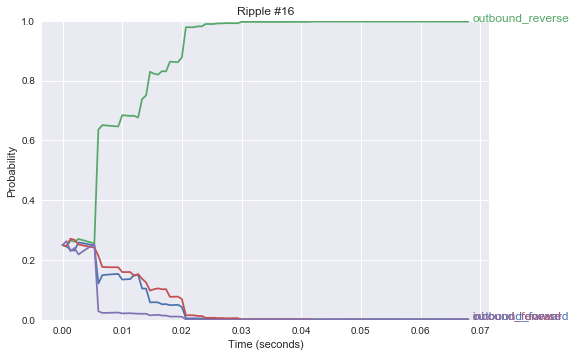

In [16]:
def browse_ripple_fits(decision_state_probability, state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_name in enumerate(state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         state_name,
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_fits(decision_state_probability, state_names)

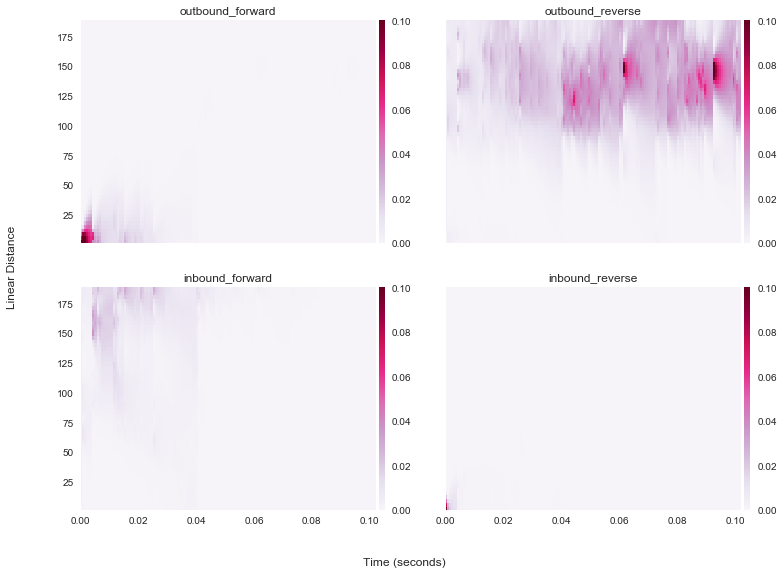

In [17]:
def browse_ripple_densities(posterior_density, state_names,
                            place_bin_centers,
                            sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9), sharex=True, sharey=True)
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        n_time = posterior_density[ripple_ind].shape[0]
        n_states = len(state_names)
        new_shape = (n_time, n_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, place_bins, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.1)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((place_bin_centers.min(), place_bin_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, cax=cax)
                ax.set_title(state_names[state_ind])
            except ValueError:
                pass
        fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
        fig.text(0.04, 0.5, 'Linear Distance', va='center', rotation='vertical')
        
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_densities(posterior_density, state_names,
                        place_bin_centers)

In [ ]:
test_spikes = [np.mean(~np.isnan(marks), axis=2)
               for marks in test_marks]
tetrode_names = [get_tetrode_name(t) for _, t in hippocampal_tetrodes.iterrows()]

In [ ]:
def browse_ripple_spikes(test_spikes, tetrode_names, sampling_frequency):
    def plot_spikes(ripple_ind):
        time = np.arange(0, test_spikes[ripple_ind].shape[0]) / sampling_frequency
        tetrode_ticks = np.arange(0, len(tetrode_names)+1);
        [time_grid, tetrode_grid] = np.meshgrid(time, tetrode_ticks)
        plt.pcolormesh(time_grid, tetrode_grid, test_spikes[ripple_ind].T)
        plt.yticks(tetrode_ticks+0.5, tetrode_names, rotation='horizontal', verticalalignment='center');
        plt.ylim(0, tetrode_ticks[-1]);
        plt.xlabel('Time (seconds)');
        plt.title('Spikes for ripple #{0}'.format(ripple_ind+1))
    interact(plot_spikes, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
    
browse_ripple_spikes(test_spikes, tetrode_names, sampling_frequency)

### Check if ripple decoding function is the same

In [20]:
%%snakeviz
from dask import multiprocessing
from dask.diagnostics import ProgressBar
with ProgressBar():
    ripple_info = decode_ripple_clusterless(
        epoch_index, animals, ripple_times,
        scheduler=multiprocessing.get, scheduler_kwargs=dict(num_workers=2))[0]

 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmp83fgfu89'. 


In [21]:
ripple_info

,ripple_trajectory,ripple_direction,ripple_state_probability,ripple_start_time,ripple_end_time,number_of_unique_neurons_spiking,number_of_spikes,session_time,is_spike
ripple_number,,,,,,,,,
1,outbound,reverse,0.873182,4137.813333,4137.874667,11,46,early,isSpike
2,outbound,reverse,0.992965,4139.667333,4139.732667,9,39,early,isSpike
3,outbound,reverse,0.988171,4142.945333,4142.986667,9,46,early,isSpike
4,inbound,reverse,0.414060,4168.426667,4168.463333,6,15,early,isSpike
5,outbound,reverse,0.809156,4197.592667,4197.628000,8,30,early,isSpike
6,inbound,forward,0.540138,4198.890667,4198.968667,11,54,early,isSpike
7,outbound,reverse,0.996253,4199.103333,4199.136667,6,27,early,isSpike
8,inbound,forward,0.708724,4251.480667,4251.528667,9,32,early,isSpike
9,outbound,reverse,0.605330,4252.046667,4252.097333,10,26,early,isSpike
